<a href="https://colab.research.google.com/github/anaroberta-cin/mba_analytics/blob/main/Forecasting_wine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **DISCIPLINA: FORECASTING**
**MBA BI & Analytics**

Aluna: Ana Roberta Siqueira Souto

04/out/22

# **CONFIGURAÇÕES GERAIS**

## **Instalando bibliotecas**

In [1]:
!pip install statsmodels

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 8.9 MB/s 
     |████████████████████████████████| 9.8 MB 7.7 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.12.2
    Uninstalling statsmodels-0.12.2:
      Successfully uninstalled statsmodels-0.12.2


## **Importando bibliotecas**

In [3]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.tsa.api as tsa
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from matplotlib.pylab import rcParams
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
import itertools #para o gridsearch
import pmdarima as pm
from sklearn.model_selection import train_test_split

In [ ]:
#from fast_ml.model_development import train_valid_test_split

In [4]:
import  warnings 
warnings.simplefilter('ignore')

In [5]:
# Configurando tamanho das imagens
rcParams['figure.figsize'] = 15, 6

## **Montando o google drive**

In [6]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [7]:
%cd /content/gdrive/MyDrive/Forecasting

!ls

/content/gdrive/MyDrive/Forecasting
 denguerj.csv						   wine.txt
'Forecasting - Ana Roberta Souto (em andamento).gslides'


## **Definindo funções**

In [8]:
# Definindo função para plotar o ACF E PACF
def acf_pacf(x, qtd_lag):
    fig = plt.figure(figsize=(16,10))
    ax1 = fig.add_subplot(221)
    fig = sm.graphics.tsa.plot_acf(x, lags=qtd_lag, ax=ax1)
    ax2 = fig.add_subplot(222)
    fig = sm.graphics.tsa.plot_pacf(x, lags=qtd_lag, ax=ax2)
    plt.show()

In [9]:
# Sliding windows para os modelos de aprendizagem de máquina
def get_lags(series, lags):
    result = []
    if lags > 0:
        for lag in range(1, lags+1):
            result.append(series.shift(lag).rename({series.columns[0]: series.columns[0]+'-'+str(lag)}, axis=1))
        return pd.concat(result, axis=1, names=list(range(-1,-lags))).dropna()
    else:
        for lag in range(-1, lags-1,-1):
            result.append(series.shift(lag).rename({series.columns[0]: series.columns[0]+'+'+str(abs(lag))}, axis=1))
        return pd.concat(result, axis=1, names=list(range(+1,-lags))).dropna()

# **LEITURA, VISUALIZAÇÃO E ANÁLISE PRELIMINAR DOS DADOS**


## **Leitura dos dados (WINE)**

In [10]:
# Obtida através do link https://github.com/Eraylson/series_temporais/blob/master/wine.txt

df = pd.read_csv('wine.txt')
display(df)
#df.tail(5)

,target
0,112
1,118
2,129
3,99
4,116
...,...
182,45
183,52
184,28
185,40


## **Visualização dos dados**

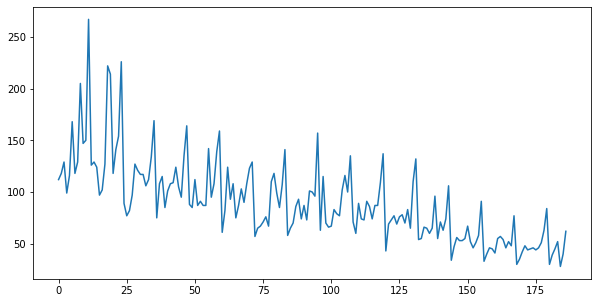

In [11]:
plt.figure(figsize=(10,5))
plt.plot(df)

In [12]:
# Existem "valores faltantes"?
df.isnull().values.any()

False

In [13]:
df.dtypes

target    int64
dtype: object

## **Decomposição e análise preliminar da série**

In [14]:
df_decomp = tsa.seasonal_decompose(df, period=12)

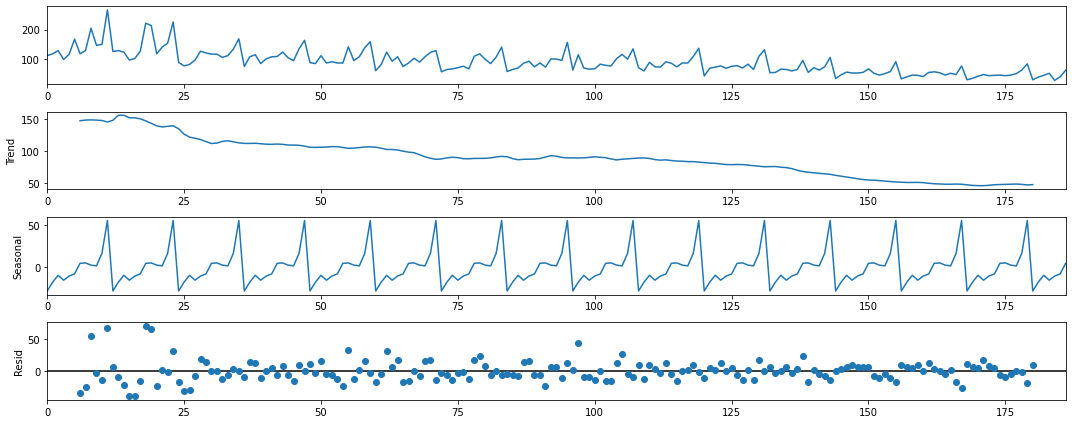

In [15]:
df_decomp.plot();

**Sazonalidade é difícil para o modelo arima e esta série demonstra que tem sazonalidade. Aparantemente, o registro da série é mensal, portanto, usarei period=12.**

# **SEPARAÇÃO DAS BASES DE TREINO E TESTE PARA ARIMA E SARIMA**

In [16]:
# são 187 observações. Separando as bases em treino (75%) e teste:
#train = df.loc[0:93]
#test = df.loc[140:186]
#valid = df.loc[94:139]

limite = round(len(df)*0.75)
train = df[:limite]
test = df[limite:]


In [17]:
if len(df) == len(train) + len(test):
  print("True")

True


# **MODELO 1: ARIMA/SARIMA (metodologia box jenkins)**
(assume que a série é linear)

## **Identificação dos parâmetros**

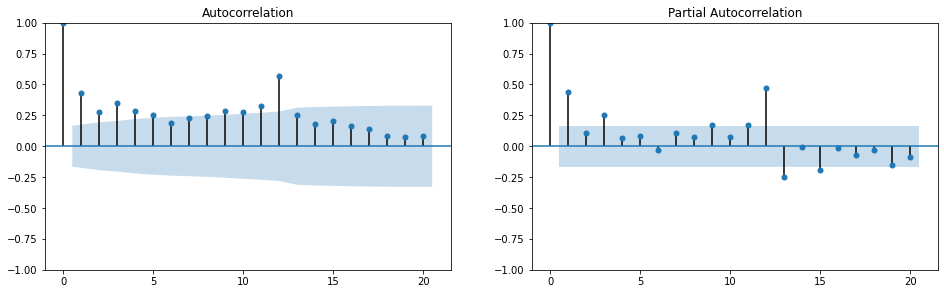

In [18]:
# parâmetro d - quantas diferenciações serão necessárias para tornar a série estacionária?
acf_pacf(train, 20)

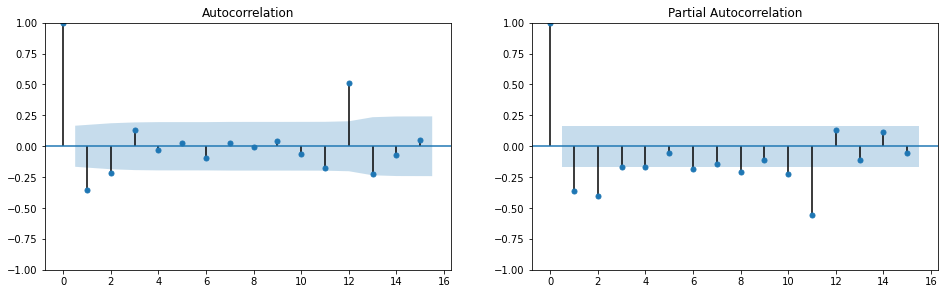

In [19]:
# aplicando uma diferenciação para avaliar
acf_pacf(train.diff().dropna(),15)

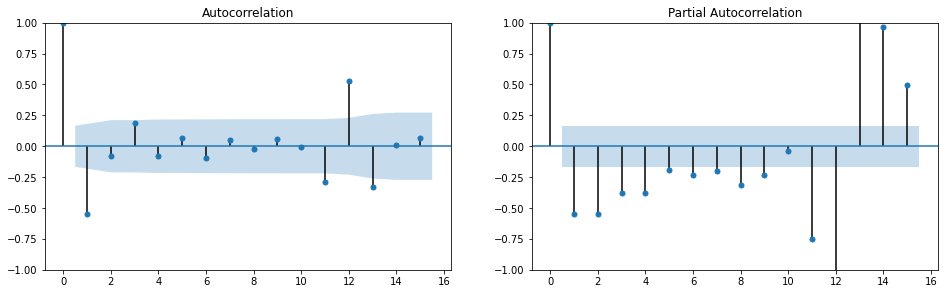

In [20]:
# aplicando mais uma diferenciação para avaliar
acf_pacf(train.diff().diff().dropna(),15)

In [21]:
# por este resultado acima, escolho a diferenciação 1
arima_d = 1

# se escolhi a diferenciação 1, vou olhar para a autocorrelação parcial para escolher meu p e vou testar primeiramente o p = 2
arima_p = 2

# olhando para a diferenciação 1 e para a autocorrelação, a 1 parece mais apropriada
arima_q = 1

In [22]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(train.target, order=(arima_p, arima_d, arima_q))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                 target   No. Observations:                  140
Model:                 ARIMA(2, 1, 1)   Log Likelihood                -673.525
Date:                Fri, 07 Oct 2022   AIC                           1355.051
Time:                        03:16:35   BIC                           1366.789
Sample:                             0   HQIC                          1359.821
                                - 140                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1715      0.076      2.260      0.024       0.023       0.320
ar.L2         -0.1053      0.101     -1.042      0.298      -0.304       0.093
ma.L1         -0.9027      0.058    -15.644      0.0

In [23]:
# testando com outros parâmetros
arima_d = 1
arima_p = 0
arima_q = 1

In [24]:
# rodando novamente para avaliar o BIC
model = ARIMA(train.target, order=(arima_p, arima_d, arima_q))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                 target   No. Observations:                  140
Model:                 ARIMA(0, 1, 1)   Log Likelihood                -675.966
Date:                Fri, 07 Oct 2022   AIC                           1355.931
Time:                        03:16:36   BIC                           1361.800
Sample:                             0   HQIC                          1358.316
                                - 140                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8933      0.050    -18.006      0.000      -0.991      -0.796
sigma2       969.4401     85.753     11.305      0.000     801.368    1137.512
Ljung-Box (L1) (Q):                   2.58   Jarque-

## **Avaliação/diagnóstico | ARIMA(0, 1, 1)**

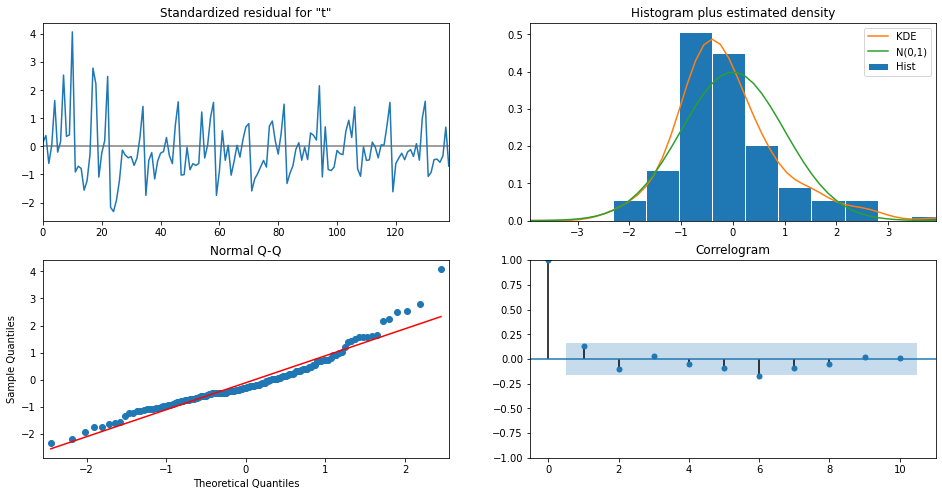

In [25]:
model_fit.plot_diagnostics(figsize=(16,8));

**Todos os resíduos estão dentro do intervalo de confiança, muitos pontos se aproximam da linha vermelha (mas poderia ser melhor) e a minha tendência de dados está um pouco distante da curva normal, o que não é o ideal. Então devo continuar setando os parâmetros para ver se melhora.**

## **Nova tentativa de parâmetros**

In [26]:
# testando com outros parâmetros
arima_d = 1
arima_p = 11
arima_q = 1

In [27]:
# rodando novamente para avaliar o BIC
model = ARIMA(train.target, order=(arima_p, arima_d, arima_q))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                 target   No. Observations:                  140
Model:                ARIMA(11, 1, 1)   Log Likelihood                -640.956
Date:                Fri, 07 Oct 2022   AIC                           1307.911
Time:                        03:16:46   BIC                           1346.060
Sample:                             0   HQIC                          1323.414
                                - 140                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0913      0.102    -10.688      0.000      -1.291      -0.891
ar.L2         -1.0981      0.126     -8.719      0.000      -1.345      -0.851
ar.L3         -0.9895      0.159     -6.228      0.0

## **Avaliação/diagnóstico | ARIMA (11,1,1)**

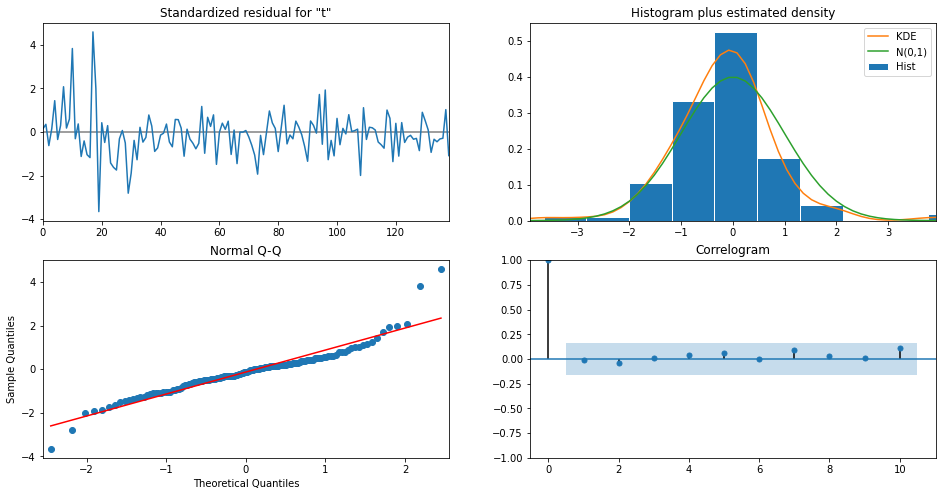

In [28]:
model_fit.plot_diagnostics(figsize=(16,8));

**Neste caso, senti um ajuste melhor à linha vermelha, o BIC melhorou mas o KNE pareceu igual em relação à linha normal. Vamos seguir o jogo para a previsão.**

## **Previsão | ARIMA(11,1,1)**

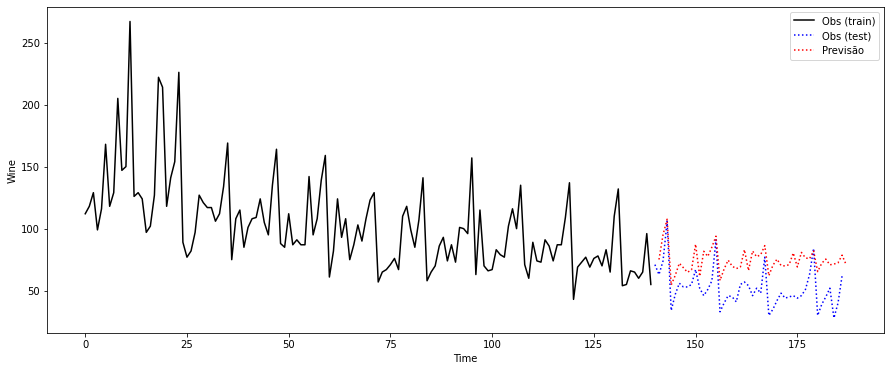

141     75.123941
142     95.147600
143    107.595877
144     54.569008
145     62.364685
146     72.106745
147     68.515129
148     64.846199
149     66.827357
150     87.464388
151     61.583297
152     81.764077
153     77.604598
154     85.073035
155     93.908874
156     58.220228
157     67.431183
158     74.617534
159     69.712957
160     67.805913
161     69.054232
162     83.030629
163     66.212337
164     81.965365
165     77.358235
166     79.027667
167     86.306241
168     62.136401
169     70.451241
170     75.393089
171     70.306761
172     69.916582
173     71.018326
174     80.397201
175     69.143671
176     80.829185
177     76.440859
178     75.728332
179     82.008535
180     65.386655
181     72.108548
182     75.467770
183     70.834727
184     71.469995
185     72.469565
186     78.615413
187     70.922120
Name: predicted_mean, dtype: float64

In [29]:
previsao = model_fit.predict(start=(len(train)+1), end=len(train+test))

obs_train = plt.plot(train.target, color='black', label='Obs (train)')
obs_test = plt.plot(test.target, color='blue', label= 'Obs (test)', linestyle='dotted')#, 'bo') 
pred = plt.plot(previsao, color='red', label='Previsão', linestyle='dotted')#, 'bo') 

plt.legend(loc='best')
plt.xlabel("Time")
plt.ylabel("Wine")
plt.show()
previsao

In [51]:
resultados = {}

In [52]:
print('ARIMA model Results')
print('mse', round(mean_squared_error(test.target, previsao),2))
print('mae', round(mean_absolute_error(test.target, previsao),2))
print('mape', round(mean_absolute_percentage_error(test.target, previsao),2))

resultados['ARIMA (11,1,1)'] = {'mse': mean_squared_error(test.target, previsao),
                  'mae': mean_absolute_error(test.target, previsao),
                  'mape': mean_absolute_percentage_error(test.target, previsao)
                  }

ARIMA model Results
mse 870.57
mae 27.61
mape 0.6


In [54]:
round(pd.DataFrame(resultados),2)

,"ARIMA (11,1,1)"
mae,27.61
mape,0.60
mse,870.57


**Esta não foi uma previsão muito boa, então vamos fazer a one-step ahead.**

### **Previsão one step ahead**

In [33]:
history = [x for x in train.target]
predictions = list()

for t in test.index:
    model = ARIMA(history, order=(arima_p, arima_d, arima_q))
    model_fit = model.fit()
    output = model_fit.forecast(alpha=0.05)
    yhat = output[0]
    predictions.append(yhat)
    obs = float(test.loc[t].values)
    history.append(obs)
    print('predicted=%f' % (yhat))

predicted=78.167889
predicted=72.632117
predicted=92.311081
predicted=101.092254
predicted=55.500026
predicted=52.673869
predicted=70.066558
predicted=61.384187
predicted=60.863416
predicted=61.031003
predicted=81.542927
predicted=51.716298
predicted=72.688689
predicted=55.594427
predicted=65.409043
predicted=83.542468
predicted=39.814602
predicted=48.064363
predicted=57.704345
predicted=49.759067
predicted=52.677333
predicted=48.719147
predicted=61.677704
predicted=49.082065
predicted=53.137841
predicted=51.206356
predicted=54.971286
predicted=73.105754
predicted=37.023296
predicted=40.644786
predicted=48.798805
predicted=44.318407
predicted=45.471223
predicted=51.743940
predicted=50.599461
predicted=50.753204
predicted=46.218776
predicted=51.409802
predicted=44.736941
predicted=70.789762
predicted=37.183210
predicted=38.814922
predicted=48.560462
predicted=46.293062
predicted=46.724503
predicted=38.565615
predicted=47.363820


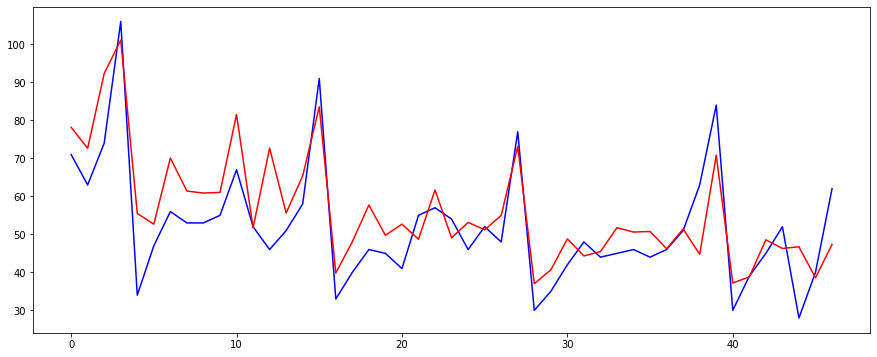

In [34]:
plt.plot(test.values, color='blue', label='Obs (train)')
plt.plot(predictions, color='red',  label='Previsão')
plt.show()

In [55]:
print('ARIMA model Results - one step ahead')
print('mse', round(mean_squared_error(test.values, predictions),2))
print('mae', round(mean_absolute_error(test.values, predictions),2))
print('mape', round(mean_absolute_percentage_error(test.values, predictions),2))

resultados['ARIMA 1step ahead'] = {'mse': mean_squared_error(test.values, predictions),
                  'mae': mean_absolute_error(test.values, predictions),
                  'mape': mean_absolute_percentage_error(test.values, predictions)
                    }

ARIMA model Results - one step ahead
mse 94.8
mae 7.84
mape 0.16


In [56]:
round(pd.DataFrame(resultados),2)

,"ARIMA (11,1,1)",ARIMA 1step ahead
mse,870.57,94.80
mae,27.61,7.84
mape,0.60,0.16


## **Buscando melhorar o conjunto de parâmetros**

### **Gridsearch**

In [37]:
p = d = q = range(0,5)
pdq = list(itertools.product(p,d,q))
pdq

[(0, 0, 0),
 (0, 0, 1),
 (0, 0, 2),
 (0, 0, 3),
 (0, 0, 4),
 (0, 1, 0),
 (0, 1, 1),
 (0, 1, 2),
 (0, 1, 3),
 (0, 1, 4),
 (0, 2, 0),
 (0, 2, 1),
 (0, 2, 2),
 (0, 2, 3),
 (0, 2, 4),
 (0, 3, 0),
 (0, 3, 1),
 (0, 3, 2),
 (0, 3, 3),
 (0, 3, 4),
 (0, 4, 0),
 (0, 4, 1),
 (0, 4, 2),
 (0, 4, 3),
 (0, 4, 4),
 (1, 0, 0),
 (1, 0, 1),
 (1, 0, 2),
 (1, 0, 3),
 (1, 0, 4),
 (1, 1, 0),
 (1, 1, 1),
 (1, 1, 2),
 (1, 1, 3),
 (1, 1, 4),
 (1, 2, 0),
 (1, 2, 1),
 (1, 2, 2),
 (1, 2, 3),
 (1, 2, 4),
 (1, 3, 0),
 (1, 3, 1),
 (1, 3, 2),
 (1, 3, 3),
 (1, 3, 4),
 (1, 4, 0),
 (1, 4, 1),
 (1, 4, 2),
 (1, 4, 3),
 (1, 4, 4),
 (2, 0, 0),
 (2, 0, 1),
 (2, 0, 2),
 (2, 0, 3),
 (2, 0, 4),
 (2, 1, 0),
 (2, 1, 1),
 (2, 1, 2),
 (2, 1, 3),
 (2, 1, 4),
 (2, 2, 0),
 (2, 2, 1),
 (2, 2, 2),
 (2, 2, 3),
 (2, 2, 4),
 (2, 3, 0),
 (2, 3, 1),
 (2, 3, 2),
 (2, 3, 3),
 (2, 3, 4),
 (2, 4, 0),
 (2, 4, 1),
 (2, 4, 2),
 (2, 4, 3),
 (2, 4, 4),
 (3, 0, 0),
 (3, 0, 1),
 (3, 0, 2),
 (3, 0, 3),
 (3, 0, 4),
 (3, 1, 0),
 (3, 1, 1),
 (3, 1, 2),
 (3,

In [38]:
bic_lista = []
best_order = []
min_ = 1e10
for param in pdq:
    mod = sm.tsa.statespace.SARIMAX(df.target, order=param)
    results = mod.fit()
    bic = round(results.bic,2)
    if bic < min_ :
        min_ = bic
        best_order = 'ARIMA{} - BIC: {}'.format(param, bic)
    bic_lista.append('ARIMA{} - BIC: {}'.format(param, bic))
bic_lista

['ARIMA(0, 0, 0) - BIC: 2250.92',
 'ARIMA(0, 0, 1) - BIC: 2090.48',
 'ARIMA(0, 0, 2) - BIC: 2030.01',
 'ARIMA(0, 0, 3) - BIC: 1987.8',
 'ARIMA(0, 0, 4) - BIC: 1960.63',
 'ARIMA(0, 1, 0) - BIC: 1855.62',
 'ARIMA(0, 1, 1) - BIC: 1780.91',
 'ARIMA(0, 1, 2) - BIC: 1781.31',
 'ARIMA(0, 1, 3) - BIC: 1784.36',
 'ARIMA(0, 1, 4) - BIC: 1788.85',
 'ARIMA(0, 2, 0) - BIC: 2032.1',
 'ARIMA(0, 2, 1) - BIC: 1857.11',
 'ARIMA(0, 2, 2) - BIC: 1780.27',
 'ARIMA(0, 2, 3) - BIC: 1779.24',
 'ARIMA(0, 2, 4) - BIC: 1782.97',
 'ARIMA(0, 3, 0) - BIC: 2231.21',
 'ARIMA(0, 3, 1) - BIC: 2032.56',
 'ARIMA(0, 3, 2) - BIC: 1863.52',
 'ARIMA(0, 3, 3) - BIC: 1795.45',
 'ARIMA(0, 3, 4) - BIC: 1796.11',
 'ARIMA(0, 4, 0) - BIC: 2439.62',
 'ARIMA(0, 4, 1) - BIC: 2230.33',
 'ARIMA(0, 4, 2) - BIC: 2037.3',
 'ARIMA(0, 4, 3) - BIC: 1874.32',
 'ARIMA(0, 4, 4) - BIC: 1815.7',
 'ARIMA(1, 0, 0) - BIC: 1866.71',
 'ARIMA(1, 0, 1) - BIC: 1798.15',
 'ARIMA(1, 0, 2) - BIC: 1798.58',
 'ARIMA(1, 0, 3) - BIC: 1801.62',
 'ARIMA(1, 0, 4) -

**Pelo grid search de 0 a 5, nenhuma combinação deu BIC melhor do que a anterior já utilizada. Não consegui rodar com valor maior que 5.**

### **Autoarima**

In [39]:
modelo_autoarima = pm.auto_arima(df, max_p=20 , max_q=20, max_d=20
                                 , seasonal=True, trace=True, information_criterion='bic'
                                 , stepwise=True)

Performing stepwise search to minimize bic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : BIC=inf, Time=0.48 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : BIC=1860.838, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : BIC=1839.769, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : BIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0]             : BIC=1855.623, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : BIC=1814.180, Time=0.11 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : BIC=1813.576, Time=0.13 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : BIC=1813.622, Time=0.17 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : BIC=inf, Time=0.26 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : BIC=inf, Time=0.20 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : BIC=inf, Time=0.31 sec
 ARIMA(3,1,0)(0,0,0)[0]             : BIC=1808.493, Time=0.08 sec
 ARIMA(2,1,0)(0,0,0)[0]             : BIC=1809.054, Time=0.06 sec
 ARIMA(4,1,0)(0,0,0)[0]             : BIC=1808.599, Time=0.10 sec
 ARIMA(3,1,1)(0,0,0)[0]             : BIC=1789.699, Time=0

In [40]:
modelo_autoarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  187
Model:               SARIMAX(0, 1, 1)   Log Likelihood                -885.230
Date:                Fri, 07 Oct 2022   AIC                           1774.460
Time:                        03:19:37   BIC                           1780.912
Sample:                             0   HQIC                          1777.075
                                - 187                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8811      0.041    -21.493      0.000      -0.961      -0.801
sigma2       790.4891     55.585     14.221      0.000     681.544     899.434
===================================================================================
Ljung-Box (L1) (Q):                   2.53   Jarque-Bera (JB):               103.51
Prob(Q):                              0.11   Prob(JB):                         0.00
Heteroskedasticity (H):               0.22   Skew:                             1.08
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

**Os meus parâmetros de antes continuam sendo melhores.**

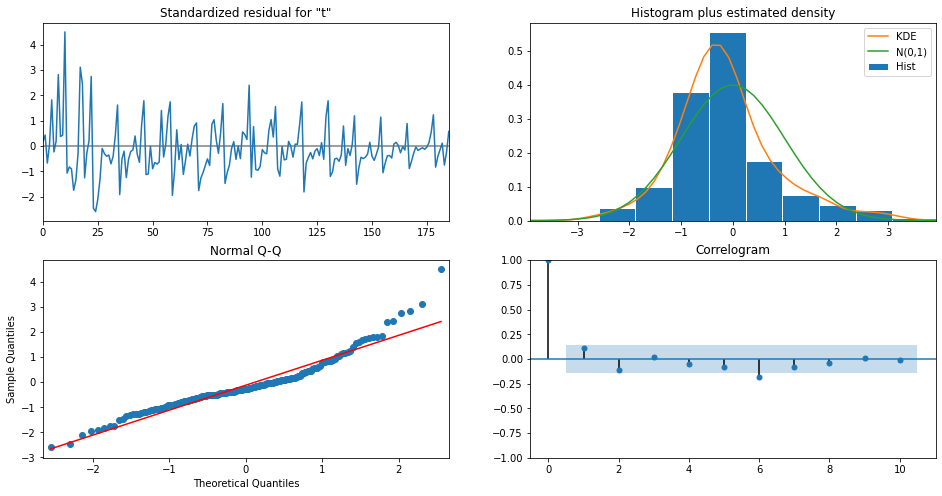

In [41]:
mod = sm.tsa.statespace.SARIMAX(df.target,
                               order=(0,1,1))
results = mod.fit()
results.plot_diagnostics(figsize=(16,8));

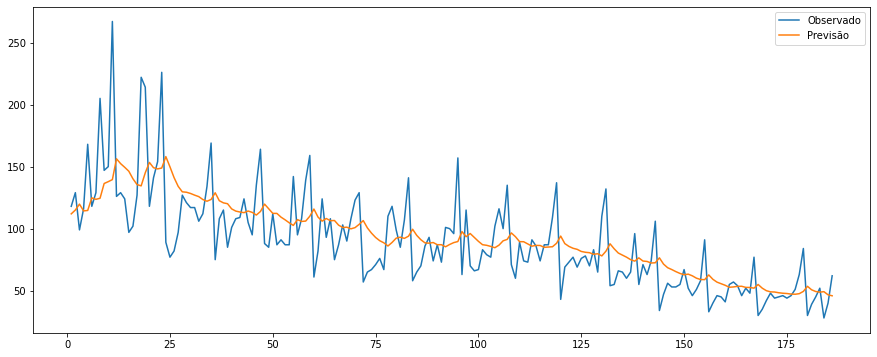

In [42]:
fitted = pd.Series(modelo_autoarima.predict_in_sample(), index=df.index)

fig, ax = plt.subplots()
ax.plot(df.iloc[1:], label='Observado')
ax.plot(fitted.iloc[1:], label='Previsão')
plt.legend()

In [57]:
print('ARIMA model Results - autoarima')
print('mse', round(mean_squared_error(df.iloc[1:], fitted.iloc[1:]),2))
print('mae', round(mean_absolute_error(df.iloc[1:], fitted.iloc[1:]),2))
print('mape', round(mean_absolute_percentage_error(df.iloc[1:], fitted.iloc[1:]),2))

mse_autoarima = round(mean_squared_error(df.iloc[1:], fitted.iloc[1:]),2)
mae_autoarima = round(mean_absolute_error(df.iloc[1:], fitted.iloc[1:]),2) 
mape_autoarima = round(mean_absolute_percentage_error(df.iloc[1:], fitted.iloc[1:]),2)

resultados['AUTOARIMA (0,1,1)'] = {'mse': mse_autoarima,
                  'mae': mae_autoarima, 'mape': mape_autoarima}


ARIMA model Results - autoarima
mse 795.36
mae 20.67
mape 0.25


In [58]:
round(pd.DataFrame(resultados),2)

,"ARIMA (11,1,1)",ARIMA 1step ahead,"AUTOARIMA (0,1,1)"
mse,870.57,94.80,795.36
mae,27.61,7.84,20.67
mape,0.60,0.16,0.25


### **Previsão com o modelo do autoarima**

In [59]:
modelo_autoarima = pm.auto_arima(train, seasonal = True, trace = True, information_criterion = 'bic', stepwise = False)
modelo_autoarima

 ARIMA(0,1,0)(0,0,0)[1] intercept   : BIC=1420.155, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[1] intercept   : BIC=inf, Time=0.14 sec
 ARIMA(0,1,2)(0,0,0)[1] intercept   : BIC=inf, Time=0.26 sec
 ARIMA(0,1,3)(0,0,0)[1] intercept   : BIC=inf, Time=0.23 sec
 ARIMA(0,1,4)(0,0,0)[1] intercept   : BIC=inf, Time=0.36 sec
 ARIMA(0,1,5)(0,0,0)[1] intercept   : BIC=inf, Time=0.43 sec
 ARIMA(1,1,0)(0,0,0)[1] intercept   : BIC=1406.204, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[1] intercept   : BIC=inf, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[1] intercept   : BIC=inf, Time=0.33 sec
 ARIMA(1,1,3)(0,0,0)[1] intercept   : BIC=inf, Time=0.46 sec
 ARIMA(1,1,4)(0,0,0)[1] intercept   : BIC=inf, Time=0.53 sec
 ARIMA(2,1,0)(0,0,0)[1] intercept   : BIC=1387.828, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[1] intercept   : BIC=inf, Time=0.17 sec
 ARIMA(2,1,2)(0,0,0)[1] intercept   : BIC=inf, Time=0.30 sec
 ARIMA(2,1,3)(0,0,0)[1] intercept   : BIC=inf, Time=0.79 sec
 ARIMA(3,1,0)(0,0,0)[1] intercept   : BIC=1389.191, Time=0.34 sec
 ARI

ARIMA(order=(2, 1, 0), scoring_args={}, seasonal_order=(0, 0, 0, 1),
      suppress_warnings=True)

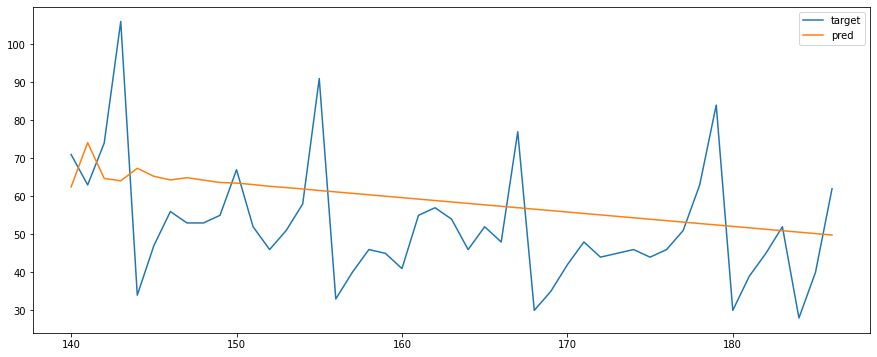

In [60]:
pred = modelo_autoarima.predict(n_periods=len(test))
pred_df = pd.DataFrame(pred, index=test.index, columns=['pred'])
pred_df = pd.concat([test, pred_df], axis=1)
pred_df.plot();

In [61]:
pred_df

,target,pred
140,71,62.470860
141,63,74.123956
142,74,64.701101
143,106,64.093055
144,34,67.374738
145,47,65.271435
146,56,64.314408
147,53,64.899803
148,53,64.270748
149,55,63.639441


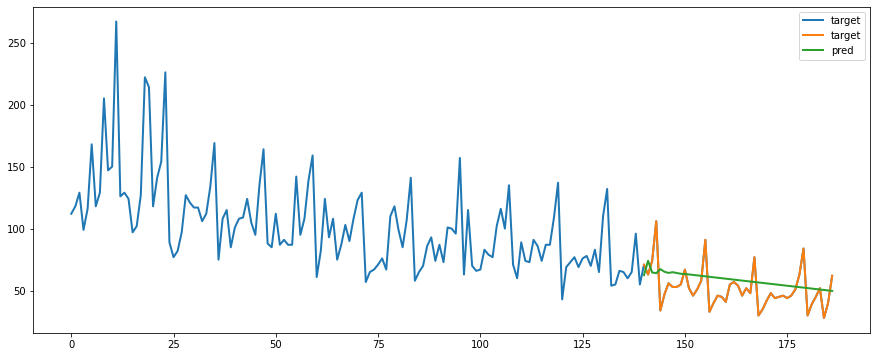

In [62]:
pd.concat([df,pred_df],axis=1).plot(linewidth=2)

**O gráfico consegue captar a tendência, não a sazonalidade.**

In [65]:
print('ARIMA model Results')
print('mse', round(mean_squared_error(pred_df.target, pred_df.pred),2))
print('mae', round(mean_absolute_error(pred_df.target, pred_df.pred),2))
print('mape', round(mean_absolute_percentage_error(pred_df.target, pred_df.pred),2))

resultados['AUTOARIMA (2,1,0)'] = {'mse': mean_squared_error(pred_df.target, pred_df.pred),
                  'mae': mean_absolute_error(pred_df.target, pred_df.pred),
                  'mape': mean_absolute_percentage_error(pred_df.target, pred_df.pred)
                  }

ARIMA model Results
mse 264.9
mae 13.63
mape 0.29


In [66]:
round(pd.DataFrame(resultados),2)

,"ARIMA (11,1,1)",ARIMA 1step ahead,"AUTOARIMA (0,1,1)","AUTOARIMA (2,1,0)"
mse,870.57,94.80,795.36,264.90
mae,27.61,7.84,20.67,13.63
mape,0.60,0.16,0.25,0.29


## **SARIMA: Estendendo para um comportamento sazonal**

### **Identificando os parâmetros**

In [67]:
modelo_autoarima = pm.auto_arima(train, max_p=20 , max_q=20, max_d=20
                                 , max_P=20, max_Q=20, max_D = 20, m=12
                                 , seasonal=True, trace=True, information_criterion='bic'
                                 , stepwise=True)
modelo_autoarima

Performing stepwise search to minimize bic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : BIC=inf, Time=1.42 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : BIC=1420.155, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : BIC=1359.329, Time=0.28 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : BIC=inf, Time=0.52 sec
 ARIMA(0,1,0)(0,0,0)[12]             : BIC=1415.236, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : BIC=1406.204, Time=0.06 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : BIC=1343.609, Time=0.51 sec
 ARIMA(1,1,0)(3,0,0)[12] intercept   : BIC=inf, Time=1.77 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : BIC=1340.161, Time=1.21 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : BIC=1335.397, Time=0.62 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : BIC=1380.363, Time=0.18 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : BIC=1340.216, Time=0.99 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : BIC=1367.884, Time=0.57 sec
 ARIMA(1,1,0)(2,0,2)[12] intercept   : BIC=inf, Time=2.21 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : 

ARIMA(order=(0, 1, 1), scoring_args={}, seasonal_order=(1, 0, 1, 12),
      suppress_warnings=True, with_intercept=False)

### **Avaliação/diagnóstico**

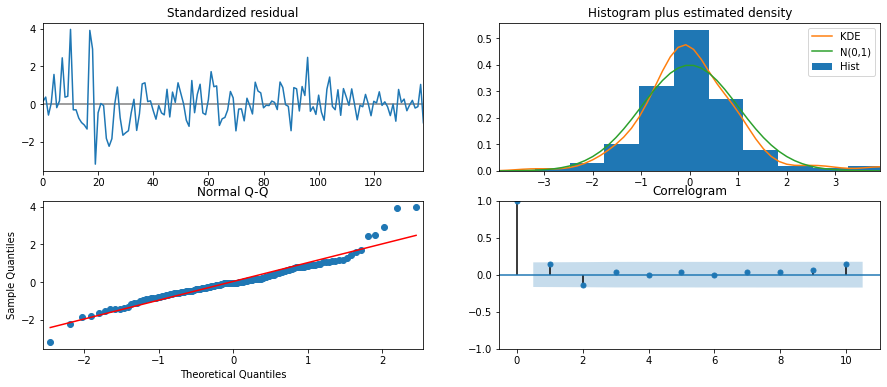

In [68]:
modelo_autoarima.plot_diagnostics();

**Este modelo pareceu melhor que o meu de antes!**

### **Previsão**

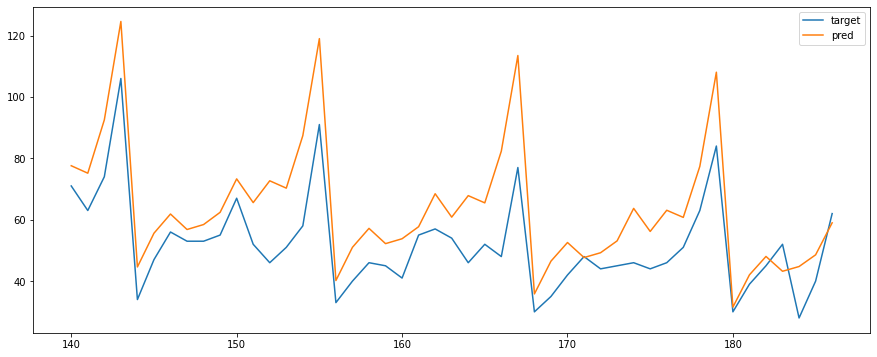

In [69]:
pred = modelo_autoarima.predict(n_periods=len(test))
pred_df = pd.DataFrame(pred, index=test.index, columns=['pred'])
pred_df = pd.concat([test, pred_df], axis=1)
pred_df.plot();

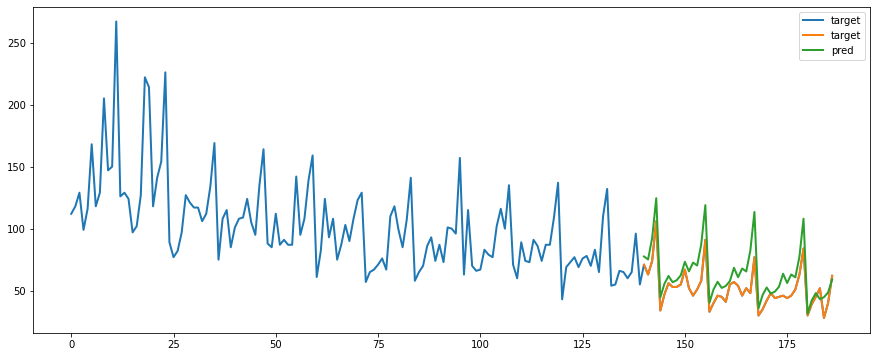

In [70]:
pd.concat([df, pred_df],axis=1).plot(linewidth=2)

In [71]:
print('SARIMA model Results')
print('mse', round(mean_squared_error(pred_df.target, pred_df.pred),2))
print('mae', round(mean_absolute_error(pred_df.target, pred_df.pred),2))
print('mape', round(mean_absolute_percentage_error(pred_df.target, pred_df.pred),2))

resultados['SARIMA'] = {'mse': mean_squared_error(pred_df.target, pred_df.pred),
                  'mae': mean_absolute_error(pred_df.target, pred_df.pred),
                  'mape': mean_absolute_percentage_error(pred_df.target, pred_df.pred)
                  }

SARIMA model Results
mse 223.2
mae 12.32
mape 0.24


In [73]:
round(pd.DataFrame(resultados),2)

,"ARIMA (11,1,1)",ARIMA 1step ahead,"AUTOARIMA (0,1,1)","AUTOARIMA (2,1,0)",SARIMA
mse,870.57,94.80,795.36,264.90,223.20
mae,27.61,7.84,20.67,13.63,12.32
mape,0.60,0.16,0.25,0.29,0.24


# **AJUSTE DA ESTRUTURA DE DADOS E SEPARAÇÃO DAS BASES DE TREINO E TESTE PARA MODELOS DE ML**

In [74]:
sliding_windows_df = get_lags(df, 5) #11 teria sido a diferenciação aparentemente mais interessante no gráfico, mas não rodou o mlp.
sliding_windows_df.head()

,target-1,target-2,target-3,target-4,target-5
5,116.0,99.0,129.0,118.0,112.0
6,168.0,116.0,99.0,129.0,118.0
7,118.0,168.0,116.0,99.0,129.0
8,129.0,118.0,168.0,116.0,99.0
9,205.0,129.0,118.0,168.0,116.0


In [75]:
#Definindo variáveis preditoras e target
X = sliding_windows_df
y = df.reindex(X.index)

In [76]:
print(X.shape)
print(y.shape)

(182, 5)
(182, 1)


In [77]:
# Existem "valores faltantes"?
X

,target-1,target-2,target-3,target-4,target-5
5,116.0,99.0,129.0,118.0,112.0
6,168.0,116.0,99.0,129.0,118.0
7,118.0,168.0,116.0,99.0,129.0
8,129.0,118.0,168.0,116.0,99.0
9,205.0,129.0,118.0,168.0,116.0
...,...,...,...,...,...
182,39.0,30.0,84.0,63.0,51.0
183,45.0,39.0,30.0,84.0,63.0
184,52.0,45.0,39.0,30.0,84.0
185,28.0,52.0,45.0,39.0,30.0


In [ ]:
#X_train, y_train, X_valid, y_valid, X_test, y_test = train_valid_test_split(X, y, train_size=0.50, valid_size=0.25, test_size=0.25)

#print(X_train.shape), print(y_train.shape)
#print(X_valid.shape), print(y_valid.shape)
#print(X_test.shape), print(y_test.shape)


In [78]:
#Separação dos dados
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.25)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(y_train[0:1])
X_train.head()

(136, 5)
(136, 1)
(46, 5)
(46, 1)
   target
5     168


,target-1,target-2,target-3,target-4,target-5
5,116.0,99.0,129.0,118.0,112.0
6,168.0,116.0,99.0,129.0,118.0
7,118.0,168.0,116.0,99.0,129.0
8,129.0,118.0,168.0,116.0,99.0
9,205.0,129.0,118.0,168.0,116.0


In [79]:
len(X_train)+len(X_test) == len(sliding_windows_df)

True

# **MODELO 2: SVR (2 splits)**

In [80]:
#Variáveis do SVR
c = 1.0
epsilon = 0.2
kernel = 'linear'

In [81]:
from sklearn.svm import SVR
model_svr = SVR(C=c, epsilon=epsilon, kernel='linear')
model_svr.fit(X_train, y_train)

SVR(epsilon=0.2, kernel='linear')

In [82]:
svr_previsao = model_svr.predict(X_test)
svr_mse = mean_squared_error(y_test, svr_previsao).round(4)
svr_mae = mean_absolute_error(y_test, svr_previsao).round(4)

print(f'kernel: {kernel}, c: {c}, epsilon: {epsilon}, MSE: {svr_mse}, MAE: {svr_mae}')

kernel: linear, c: 1.0, epsilon: 0.2, MSE: 454.5102, MAE: 17.3425


In [84]:
print('MVK - SVR model Results')
print(mean_squared_error(model_svr.predict(X_test), y_test))
print(mean_absolute_error(model_svr.predict(X_test), y_test))
print(mean_absolute_percentage_error(model_svr.predict(X_test), y_test))
resultados['SVR 2 splits'] = {'mse': mean_squared_error(model_svr.predict(X_test), y_test),
                  'mae': mean_absolute_error(model_svr.predict(X_test), y_test),
                  'mape': mean_absolute_percentage_error(model_svr.predict(X_test), y_test)
                  }

MVK - SVR model Results
454.5101741666338
17.342469649780192
0.2564359251182556


In [85]:
round(pd.DataFrame(resultados),2)

,"ARIMA (11,1,1)",ARIMA 1step ahead,"AUTOARIMA (0,1,1)","AUTOARIMA (2,1,0)",SARIMA,SVR 2 splits
mse,870.57,94.80,795.36,264.90,223.20,454.51
mae,27.61,7.84,20.67,13.63,12.32,17.34
mape,0.60,0.16,0.25,0.29,0.24,0.26


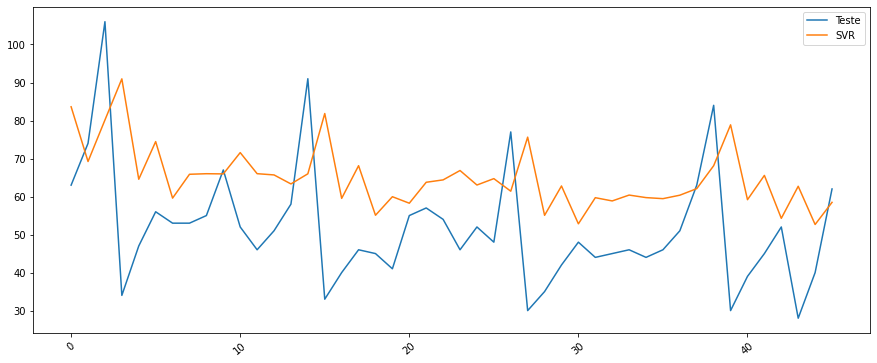

In [86]:
fig, ax = plt.subplots()
ax.plot(y_test.values, label='Teste')
ax.plot(svr_previsao, label='SVR')

plt.xticks(rotation=40)
plt.legend()

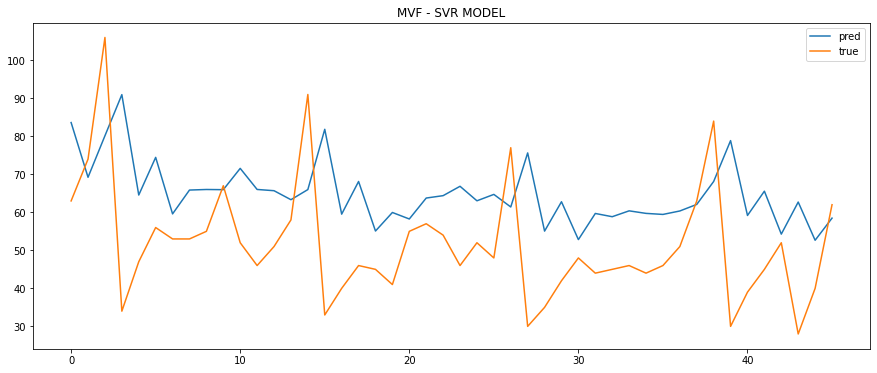

In [87]:
fig, ax = plt.subplots()
ax.plot(model_svr.predict(X_test), label='pred')
ax.plot(y_test.reset_index(drop=True), label='true')
plt.title('MVF - SVR MODEL')
plt.legend()

In [ ]:
# deu ruim, não roda. não é possível?

residuals = model_svr.predict(X_test)-y_test
residuals.rename(columns={"target": "Residuals"}, inplace=True)
residuals.plot(label="Residuals")
residuals.plot.kde()
plot_acf(residuals, lags=10);

from statsmodels.tsa.stattools import adfuller

adf = adfuller(residuals)
print(f'p-valor: {round(adf[1],2)}')

# **MODELO SVR COM GRID SEARCH (3 splits)**

In [88]:
train_len = round(len(sliding_windows_df)*0.5); print(train_len)
valid_len = round(len(sliding_windows_df)*0.25); print(valid_len)
test_len = round(len(sliding_windows_df)*0.25); print(test_len)

X_train = sliding_windows_df.iloc[:train_len]
y_train = df.reindex(X_train.index)

X_valid = sliding_windows_df.iloc[train_len:(train_len+valid_len)]
y_valid = df.reindex(X_valid.index)

X_test = sliding_windows_df.iloc[(train_len+valid_len)-1:]
y_test = df.reindex(X_test.index)

91
46
46


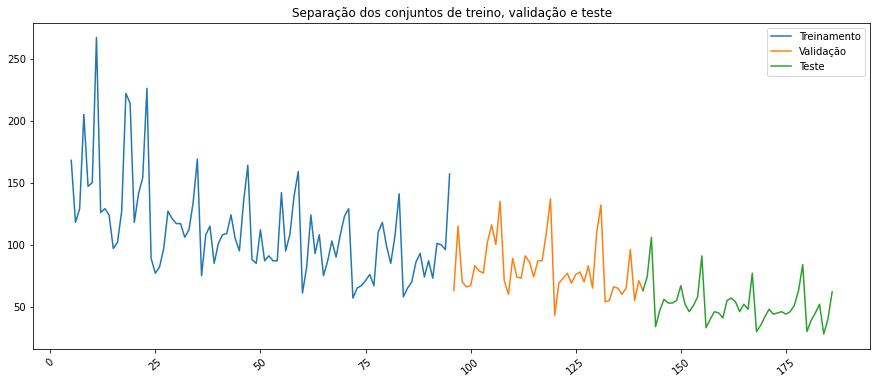

In [89]:
fig, ax = plt.subplots()
ax.plot(y_train, label='Treinamento')
ax.plot(y_valid, label='Validação')
ax.plot(y_test, label='Teste')

plt.title('Separação dos conjuntos de treino, validação e teste')
plt.xticks(rotation=40)
plt.legend()

In [90]:
param_kernel = ['linear', 'rbf']
param_C = [0.1,1,10]
param_epsilon = [0.2, 0.1, 0.001, 0.0001]

In [96]:
mse_min = 1e9
best_param= []
best_previsao = []

for kernel in param_kernel:
  for c in param_C:
    for epsilon in param_epsilon:

      model_svr = SVR(C=c, epsilon=epsilon, kernel=kernel)
      model_svr.fit(X_train, y_train)

      svr_previsao = model_svr.predict(X_valid)
      svr_mse = mean_squared_error(y_valid, svr_previsao).round(4)
      svr_mae = mean_absolute_error(y_valid, svr_previsao).round(4)
      svr_mape = mean_absolute_percentage_error(y_valid, svr_previsao).round(4)
      svr_mse_test = mean_squared_error(y_test, svr_previsao).round(4)
      svr_mae_test = mean_absolute_error(y_test, svr_previsao).round(4)
      svr_mape_test = mean_absolute_percentage_error(y_test, svr_previsao).round(4)

      print(f'kernel: {kernel}, c: {c}, epsilon: {epsilon}, MSE Valid: {svr_mse}, MAE Valid: {svr_mae}, MAPE Valid: {svr_mape}, MSE Test: {svr_mse_test}, MAE Test: {svr_mae_test}, MAPE Test: {svr_mape_test}')

      if svr_mse < mse_min:
        mse_min = svr_mse
        best_param = {'kernel':kernel, 'c':c, 'epsilon':epsilon, 'MSE Valid':svr_mse, 'MAE Valid':svr_mae, 'MAPE Valid':svr_mape, 'MSE Test':svr_mse_test, 'MAE Test':svr_mae_test, 'MAPE Test':svr_mape_test}
        best_previsao = svr_previsao

best_param


kernel: linear, c: 0.1, epsilon: 0.2, MSE Valid: 695.5069, MAE Valid: 20.6653, MAPE Valid: 0.294, MSE Test: 1747.8005, MAE Test: 39.2957, MAPE Test: 0.8694
kernel: linear, c: 0.1, epsilon: 0.1, MSE Valid: 695.2094, MAE Valid: 20.6434, MAPE Valid: 0.2936, MSE Test: 1744.0695, MAE Test: 39.2351, MAPE Test: 0.8681
kernel: linear, c: 0.1, epsilon: 0.001, MSE Valid: 694.7877, MAE Valid: 20.6248, MAPE Valid: 0.2933, MSE Test: 1741.1336, MAE Test: 39.1861, MAPE Test: 0.8672
kernel: linear, c: 0.1, epsilon: 0.0001, MSE Valid: 694.7831, MAE Valid: 20.6246, MAPE Valid: 0.2933, MSE Test: 1741.102, MAE Test: 39.1856, MAPE Test: 0.8672
kernel: linear, c: 1, epsilon: 0.2, MSE Valid: 696.0051, MAE Valid: 20.6727, MAPE Valid: 0.2941, MSE Test: 1748.5509, MAE Test: 39.3026, MAPE Test: 0.8695
kernel: linear, c: 1, epsilon: 0.1, MSE Valid: 696.2834, MAE Valid: 20.6627, MAPE Valid: 0.294, MSE Test: 1747.8687, MAE Test: 39.2809, MAPE Test: 0.8689
kernel: linear, c: 1, epsilon: 0.001, MSE Valid: 697.3826, M

{'kernel': 'linear',
 'c': 0.1,
 'epsilon': 0.0001,
 'MSE Valid': 694.7831,
 'MAE Valid': 20.6246,
 'MAPE Valid': 0.2933,
 'MSE Test': 1741.102,
 'MAE Test': 39.1856,
 'MAPE Test': 0.8672}

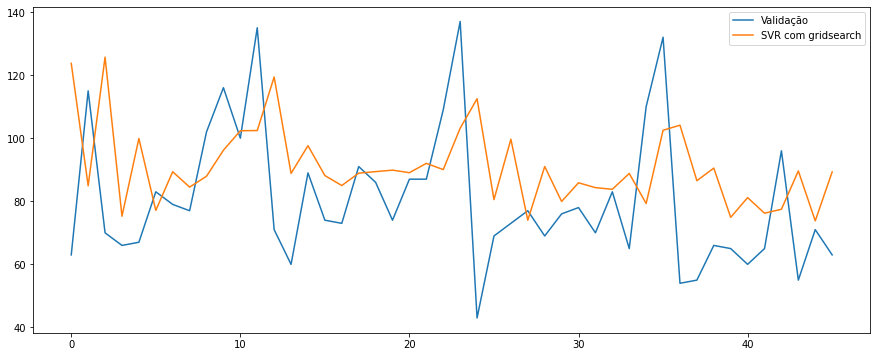

In [92]:
fig, ax = plt.subplots()
ax.plot(y_valid.values, label='Validação')
ax.plot(best_previsao, label='SVR com gridsearch')

plt.legend()

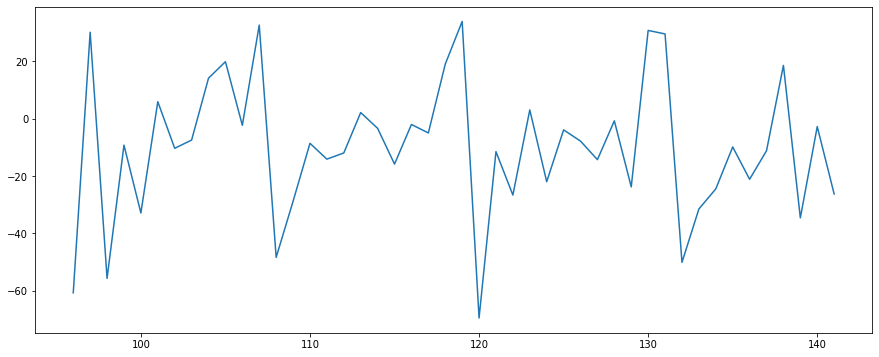

In [93]:
erro_validacao = y_valid.target - best_previsao
erro_validacao.plot()

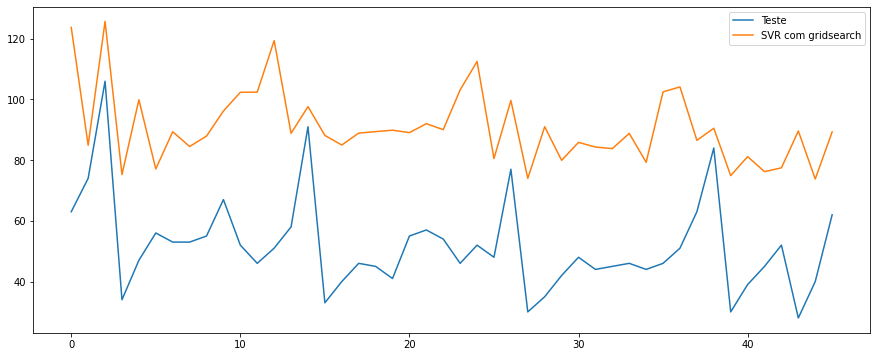

In [94]:
fig, ax = plt.subplots()
ax.plot(y_test.values, label='Teste')
ax.plot(best_previsao, label='SVR com gridsearch')

plt.legend()

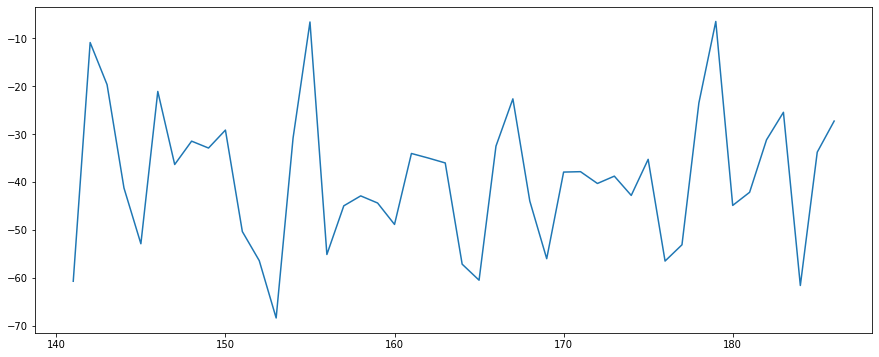

In [95]:
erro_teste = y_test.target - best_previsao
erro_teste.plot()

In [97]:
print('SVR model Results - Grid Search e 3 splits')
print(mean_squared_error(model_svr.predict(X_test), y_test))
print(mean_absolute_error(model_svr.predict(X_test), y_test))
print(mean_absolute_percentage_error(model_svr.predict(X_test), y_test))

resultados['SVR 3s GS Valid'] = {'mse': svr_mse, 'mae': svr_mae, 'mape': svr_mape}
resultados['SVR 3s GS Teste'] = {'mse': svr_mse_test, 'mae': svr_mae_test, 'mape': svr_mape_test}


SVR model Results - Grid Search e 3 splits
1980.4871935419378
42.06989107682418
0.4508168447996664


In [98]:
round(pd.DataFrame(resultados),2)

,"ARIMA (11,1,1)",ARIMA 1step ahead,"AUTOARIMA (0,1,1)","AUTOARIMA (2,1,0)",SARIMA,SVR 2 splits,SVR 3s GS Valid,SVR 3s GS Teste
mse,870.57,94.80,795.36,264.90,223.20,454.51,719.25,2011.79
mae,27.61,7.84,20.67,13.63,12.32,17.34,22.48,42.62
mape,0.60,0.16,0.25,0.29,0.24,0.26,0.32,0.95


# **MODELO SVR (3 splits) COM GRID SEARCH E JANELA 11**

In [99]:
sliding_windows_df11 = get_lags(df, 11) #11 por ter sido a diferenciação aparentemente mais interessante no gráfico
sliding_windows_df11.head()

,target-1,target-2,target-3,target-4,target-5,target-6,target-7,target-8,target-9,target-10,target-11
11,150.0,147.0,205.0,129.0,118.0,168.0,116.0,99.0,129.0,118.0,112.0
12,267.0,150.0,147.0,205.0,129.0,118.0,168.0,116.0,99.0,129.0,118.0
13,126.0,267.0,150.0,147.0,205.0,129.0,118.0,168.0,116.0,99.0,129.0
14,129.0,126.0,267.0,150.0,147.0,205.0,129.0,118.0,168.0,116.0,99.0
15,124.0,129.0,126.0,267.0,150.0,147.0,205.0,129.0,118.0,168.0,116.0


In [100]:
#Definindo variáveis preditoras e target
X2 = sliding_windows_df11
y2 = df.reindex(X2.index)

In [101]:
print(X2.shape)
print(y2.shape)

(176, 11)
(176, 1)


In [102]:
train2_len = round(len(sliding_windows_df11)*0.5); print(train2_len)
valid2_len = round(len(sliding_windows_df11)*0.25); print(valid2_len)
test2_len = round(len(sliding_windows_df11)*0.25); print(test2_len)

X2_train = sliding_windows_df11.iloc[:train2_len]
y2_train = df.reindex(X2_train.index)

X2_valid = sliding_windows_df11.iloc[train2_len:(train2_len+valid2_len)]
y2_valid = df.reindex(X2_valid.index)

X2_test = sliding_windows_df11.iloc[(train2_len+valid2_len):]
y2_test = df.reindex(X2_test.index)

88
44
44


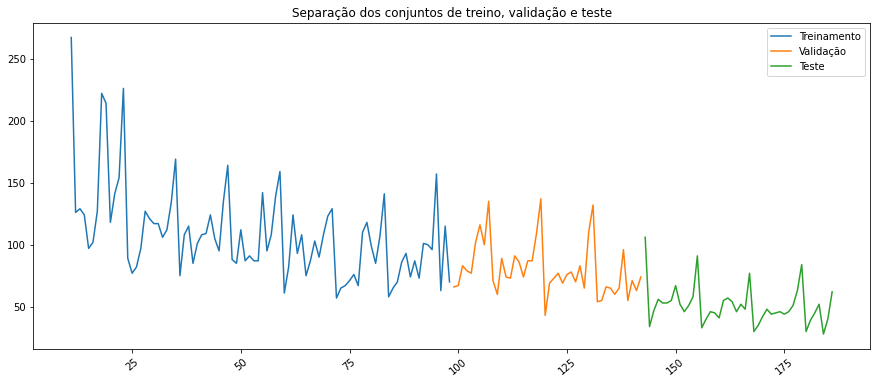

In [103]:
fig, ax = plt.subplots()
ax.plot(y2_train, label='Treinamento')
ax.plot(y2_valid, label='Validação')
ax.plot(y2_test, label='Teste')

plt.title('Separação dos conjuntos de treino, validação e teste')
plt.xticks(rotation=40)
plt.legend()

In [104]:
param_kernel = ['linear', 'rbf']
param_C = [0.1,1,10]
param_epsilon = [0.2, 0.1, 0.001, 0.0001]

In [105]:
mse_min = 1e9
best_param2= []
best_previsao2 = []

for kernel in param_kernel:
  for c in param_C:
    for epsilon in param_epsilon:

      model_svr2 = SVR(C=c, epsilon=epsilon, kernel=kernel)
      model_svr2.fit(X2_train, y2_train)

      svr_previsao2 = model_svr2.predict(X2_valid)
      svr_mse2 = mean_squared_error(y2_valid, svr_previsao2).round(4)
      svr_mae2 = mean_absolute_error(y2_valid, svr_previsao2).round(4)
      svr_mape2 = mean_absolute_percentage_error(y2_valid, svr_previsao2).round(4)
      svr_mse_test2 = mean_squared_error(y2_test, svr_previsao2).round(4)
      svr_mae_test2 = mean_absolute_error(y2_test, svr_previsao2).round(4)
      svr_mape_test2 = mean_absolute_percentage_error(y2_test, svr_previsao2).round(4)

      print(f'kernel: {kernel}, c: {c}, epsilon: {epsilon}, MSE Valid: {svr_mse2}, MAE Valid: {svr_mae2}, MAPE Valid: {svr_mape2}, MSE Test: {svr_mse_test2}, MAE Test: {svr_mae_test2}, MAPE Test: {svr_mape_test2}')

      if svr_mse2 < mse_min:
        mse_min = svr_mse2
        best_param2 = {'kernel':kernel, 'c':c, 'epsilon':epsilon, 'MSE Valid':svr_mse2, 'MAE Valid':svr_mae2, 'MAPE Valid':svr_mape2, 'MSE Test':svr_mse_test2, 'MAE Test':svr_mae_test2, 'MAPE Test':svr_mape_test2}
        best_previsao2 = svr_previsao2

best_param2


kernel: linear, c: 0.1, epsilon: 0.2, MSE Valid: 508.0483, MAE Valid: 17.8933, MAPE Valid: 0.2332, MSE Test: 1525.0796, MAE Test: 36.8006, MAPE Test: 0.8209
kernel: linear, c: 0.1, epsilon: 0.1, MSE Valid: 508.2417, MAE Valid: 17.8796, MAPE Valid: 0.2327, MSE Test: 1517.8391, MAE Test: 36.7021, MAPE Test: 0.8185
kernel: linear, c: 0.1, epsilon: 0.001, MSE Valid: 508.4759, MAE Valid: 17.8659, MAPE Valid: 0.2322, MSE Test: 1510.6866, MAE Test: 36.6041, MAPE Test: 0.8161
kernel: linear, c: 0.1, epsilon: 0.0001, MSE Valid: 508.4748, MAE Valid: 17.8657, MAPE Valid: 0.2322, MSE Test: 1510.5917, MAE Test: 36.6028, MAPE Test: 0.8161
kernel: linear, c: 1, epsilon: 0.2, MSE Valid: 508.0659, MAE Valid: 17.8937, MAPE Valid: 0.2332, MSE Test: 1525.1779, MAE Test: 36.8018, MAPE Test: 0.8209
kernel: linear, c: 1, epsilon: 0.1, MSE Valid: 508.2575, MAE Valid: 17.88, MAPE Valid: 0.2327, MSE Test: 1517.9247, MAE Test: 36.703, MAPE Test: 0.8185
kernel: linear, c: 1, epsilon: 0.001, MSE Valid: 508.4713, M

{'kernel': 'linear',
 'c': 0.1,
 'epsilon': 0.2,
 'MSE Valid': 508.0483,
 'MAE Valid': 17.8933,
 'MAPE Valid': 0.2332,
 'MSE Test': 1525.0796,
 'MAE Test': 36.8006,
 'MAPE Test': 0.8209}

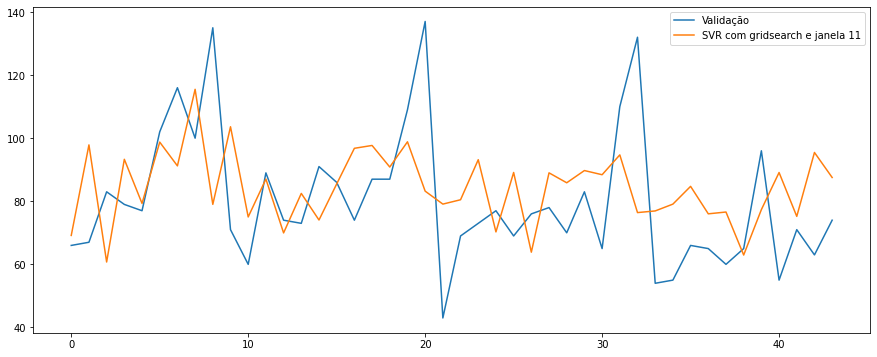

In [106]:
fig, ax = plt.subplots()
ax.plot(y2_valid.values, label='Validação')
ax.plot(best_previsao2, label='SVR com gridsearch e janela 11')

plt.legend()

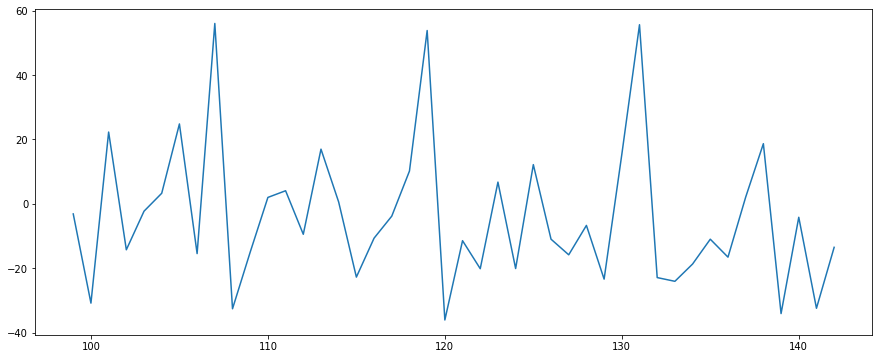

In [107]:
erro_validacao2 = y2_valid.target - best_previsao2
erro_validacao2.plot()

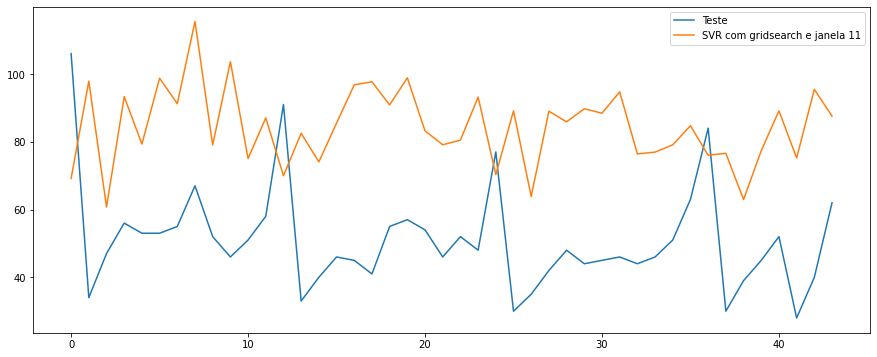

In [108]:
fig, ax = plt.subplots()
ax.plot(y2_test.values, label='Teste')
ax.plot(best_previsao2, label='SVR com gridsearch e janela 11')

plt.legend()

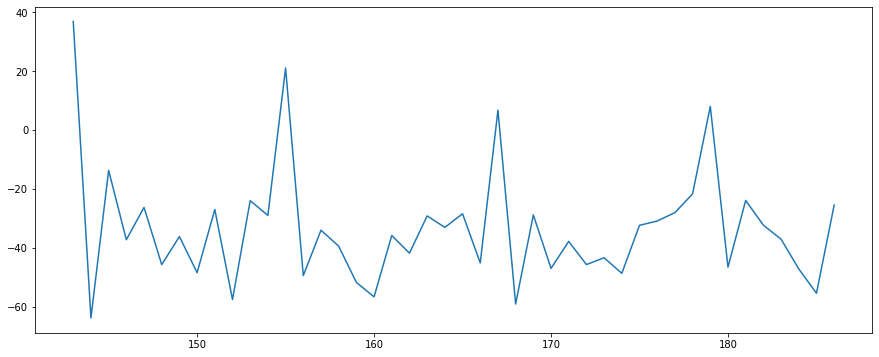

In [109]:
erro_teste2 = y2_test.target - best_previsao2
erro_teste2.plot()

In [110]:
resultados['SVR 3s GS Valid J11'] = {'mse': svr_mse2, 'mae': svr_mae2, 'mape': svr_mape2}
resultados['SVR 3s GS Teste J11'] = {'mse': svr_mse_test2, 'mae': svr_mae_test2, 'mape': svr_mape_test2}

In [111]:
round(pd.DataFrame(resultados),2)

,"ARIMA (11,1,1)",ARIMA 1step ahead,"AUTOARIMA (0,1,1)","AUTOARIMA (2,1,0)",SARIMA,SVR 2 splits,SVR 3s GS Valid,SVR 3s GS Teste,SVR 3s GS Valid J11,SVR 3s GS Teste J11
mse,870.57,94.80,795.36,264.90,223.20,454.51,719.25,2011.79,705.78,2266.77
mae,27.61,7.84,20.67,13.63,12.32,17.34,22.48,42.62,23.01,45.60
mape,0.60,0.16,0.25,0.29,0.24,0.26,0.32,0.95,0.33,1.03


# **MODELO SVR (2 splits) COM GRIDSEARCH E CROSS VALIDATION**

In [112]:
from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit

In [113]:
parameters = {'kernel':['linear', 'rbf'],
              'C': [0.1,0.2,1,10],
              'epsilon': [0.1,0.001,0.0001]
              }

parameters

{'kernel': ['linear', 'rbf'],
 'C': [0.1, 0.2, 1, 10],
 'epsilon': [0.1, 0.001, 0.0001]}

In [114]:
svr = SVR()
svr_GSCV = GridSearchCV(svr,
                        parameters,
                        cv = TimeSeriesSplit(),
                        n_jobs = -1,
                        )

In [115]:
%%time

res_GSCV = svr_GSCV.fit(X_train, y_train.values.ravel())
res_GSCV.best_params_

CPU times: user 274 ms, sys: 74.9 ms, total: 349 ms
Wall time: 2.81 s


{'C': 10, 'epsilon': 0.1, 'kernel': 'rbf'}

In [116]:
pd.DataFrame(res_GSCV.cv_results_) #visualiza as métricas e ranking de cada validação realizada 

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_epsilon,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.005457,0.001584,0.004012,0.002557,0.1,0.1,linear,"{'C': 0.1, 'epsilon': 0.1, 'kernel': 'linear'}",-1.920949,-0.761524,-0.327579,-0.389892,-0.112262,-0.702441,0.644170,13
1,0.005067,0.000947,0.003243,0.001178,0.1,0.1,rbf,"{'C': 0.1, 'epsilon': 0.1, 'kernel': 'rbf'}",-0.014795,-0.829331,-0.334804,-1.069359,-0.361210,-0.521900,0.377414,10
2,0.006594,0.002126,0.003260,0.001133,0.1,0.001,linear,"{'C': 0.1, 'epsilon': 0.001, 'kernel': 'linear'}",-1.926270,-0.766977,-0.329783,-0.385289,-0.112660,-0.704196,0.646407,14
3,0.005555,0.002060,0.003301,0.001399,0.1,0.001,rbf,"{'C': 0.1, 'epsilon': 0.001, 'kernel': 'rbf'}",-0.014599,-0.837363,-0.334804,-1.069359,-0.361210,-0.523467,0.378787,11
4,0.005019,0.002351,0.003542,0.001878,0.1,0.0001,linear,"{'C': 0.1, 'epsilon': 0.0001, 'kernel': 'linear'}",-1.926394,-0.767031,-0.329799,-0.385230,-0.112667,-0.704224,0.646457,15
5,0.003158,0.000193,0.002366,0.000036,0.1,0.0001,rbf,"{'C': 0.1, 'epsilon': 0.0001, 'kernel': 'rbf'}",-0.014596,-0.837363,-0.334826,-1.069359,-0.361210,-0.523471,0.378785,12
6,0.005423,0.001546,0.003567,0.002095,0.2,0.1,linear,"{'C': 0.2, 'epsilon': 0.1, 'kernel': 'linear'}",-1.920969,-0.774367,-0.327580,-0.389900,-0.112273,-0.705018,0.644430,16
7,0.004080,0.002134,0.002466,0.000297,0.2,0.1,rbf,"{'C': 0.2, 'epsilon': 0.1, 'kernel': 'rbf'}",-0.015170,-0.827079,-0.328152,-1.044938,-0.361837,-0.515435,0.370520,7
8,0.008593,0.003298,0.002783,0.000530,0.2,0.001,linear,"{'C': 0.2, 'epsilon': 0.001, 'kernel': 'linear'}",-1.926301,-0.780150,-0.329780,-0.385318,-0.112666,-0.706843,0.646692,17
9,0.002880,0.000144,0.002246,0.000108,0.2,0.001,rbf,"{'C': 0.2, 'epsilon': 0.001, 'kernel': 'rbf'}",-0.014843,-0.834652,-0.328182,-1.044938,-0.361837,-0.516890,0.371890,8


In [117]:
svr_gscv_previsao = res_GSCV.predict(X_test)
svr_gscv_previsao

array([90.6889288 , 86.0343643 , 90.11911262, 94.02685184, 87.01754836,
       91.46870748, 89.66131633, 92.08604154, 93.59567553, 91.28111761,
       90.49539579, 89.63443882, 90.42577303, 90.6776386 , 90.84398712,
       93.17427351, 91.3684818 , 93.30296913, 92.9684753 , 94.08686543,
       97.07024748, 95.31396446, 93.5226515 , 92.72434517, 92.16100802,
       91.33072887, 91.73004048, 92.74108558, 93.02703847, 95.1503709 ,
       95.83337518, 95.74666702, 97.72198915, 96.25231493, 95.05372534,
       94.81946414, 95.08109347, 94.48105955, 93.36996283, 92.48860926,
       91.35379571, 93.35658941, 93.23525137, 94.54510809, 98.2549737 ,
       97.6655802 ])

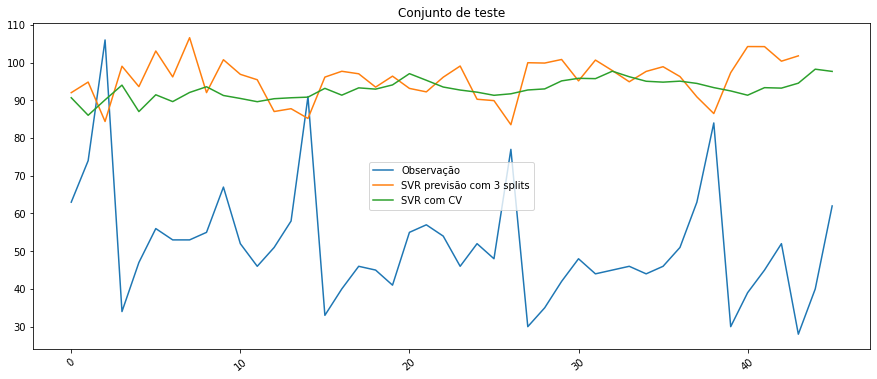

In [118]:
fig, ax = plt.subplots()
ax.plot(y_test.values, label='Observação')
ax.plot(svr_previsao2, label = 'SVR previsão com 3 splits')
ax.plot(svr_gscv_previsao, label='SVR com CV')
plt.title('Conjunto de teste')
plt.xticks(rotation=40)
plt.legend()

In [119]:
svr_GSCV_mse = mean_squared_error(y_test, svr_gscv_previsao).round(4)
svr_GSCV_mae = mean_absolute_error(y_test, svr_gscv_previsao).round(4)
svr_GSCV_mape = mean_absolute_percentage_error(y_test, svr_gscv_previsao).round(4)

resultados['SVR_GSCV'] = {'mse': svr_GSCV_mse, 'mae':svr_GSCV_mae, 'mape': svr_GSCV_mape}
print(f'Modelo SVR GSCV -> mse: {svr_GSCV_mse} | mae: {svr_GSCV_mae} | mape: {svr_GSCV_mape}')

Modelo SVR GSCV -> mse: 1980.0382 | mae: 42.0666 | mape: 0.9548


In [120]:
round(pd.DataFrame(resultados),2)

,"ARIMA (11,1,1)",ARIMA 1step ahead,"AUTOARIMA (0,1,1)","AUTOARIMA (2,1,0)",SARIMA,SVR 2 splits,SVR 3s GS Valid,SVR 3s GS Teste,SVR 3s GS Valid J11,SVR 3s GS Teste J11,SVR_GSCV
mse,870.57,94.80,795.36,264.90,223.20,454.51,719.25,2011.79,705.78,2266.77,1980.04
mae,27.61,7.84,20.67,13.63,12.32,17.34,22.48,42.62,23.01,45.60,42.07
mape,0.60,0.16,0.25,0.29,0.24,0.26,0.32,0.95,0.33,1.03,0.95


# **MODELO 4: MLP**

In [121]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [122]:
# Criando o modelo
model_mlp = Sequential()
model_mlp.add(Dense(16, input_shape=(5,), activation='relu'))
model_mlp.add(Dense(16, activation='relu'))
model_mlp.add(Dense(1, activation='linear'))

# Configurando e treinando o modelo
model_mlp.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_squared_error'])
model_mlp.fit(X_train, y_train, epochs=250, batch_size=1, verbose=False, validation_split=0.25)

In [123]:
pred_mlp = model_mlp.predict(X_test)

In [125]:
print('MLP model Results')
print(mean_squared_error(model_mlp.predict(X_test), y_test))
print(mean_absolute_percentage_error(model_mlp.predict(X_test), y_test))
print(mean_absolute_error(model_mlp.predict(X_test), y_test))
resultados['MLP'] = {'mse': mean_squared_error(model_mlp.predict(X_test), y_test),
                  'mape': mean_absolute_percentage_error(model_mlp.predict(X_test), y_test),
                  'mae': mean_absolute_error(model_mlp.predict(X_test), y_test)}

MLP model Results
317.6594224112164
0.29077365105802583
14.503898288892662


In [126]:
round(pd.DataFrame(resultados),2)

,"ARIMA (11,1,1)",ARIMA 1step ahead,"AUTOARIMA (0,1,1)","AUTOARIMA (2,1,0)",SARIMA,SVR 2 splits,SVR 3s GS Valid,SVR 3s GS Teste,SVR 3s GS Valid J11,SVR 3s GS Teste J11,SVR_GSCV,MLP
mse,870.57,94.80,795.36,264.90,223.20,454.51,719.25,2011.79,705.78,2266.77,1980.04,317.66
mae,27.61,7.84,20.67,13.63,12.32,17.34,22.48,42.62,23.01,45.60,42.07,14.50
mape,0.60,0.16,0.25,0.29,0.24,0.26,0.32,0.95,0.33,1.03,0.95,0.29


In [127]:
mlp_previsao = model_mlp.predict(X_test)

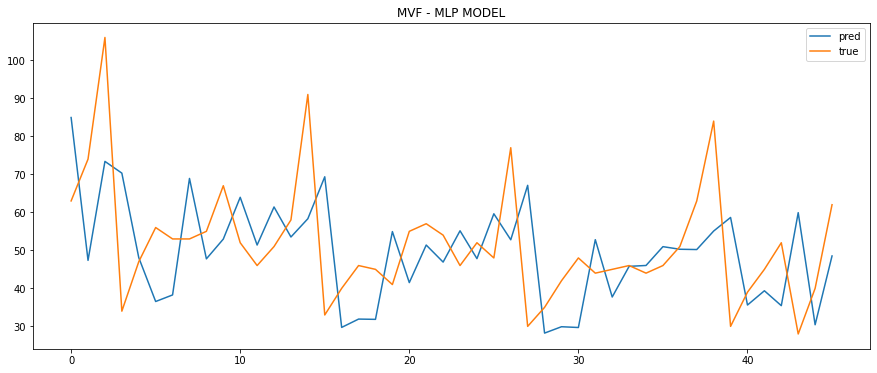

In [128]:
fig, ax = plt.subplots()
ax.plot(model_mlp.predict(X_test), label='pred')
ax.plot(y_test.reset_index(drop=True), label='true')
plt.title('MVF - MLP MODEL')
plt.legend()

p-valor: 0.0001


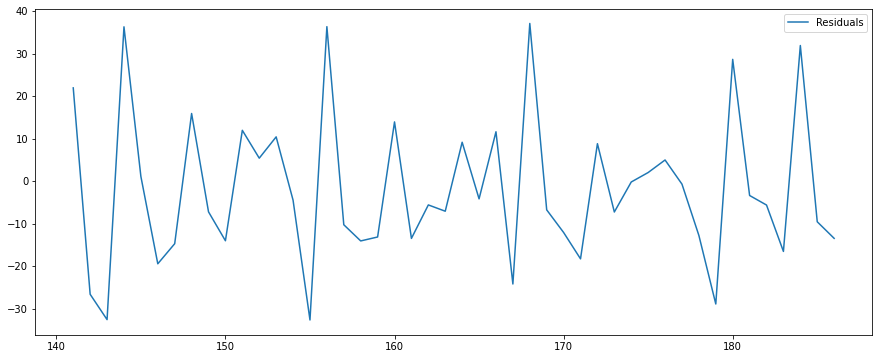

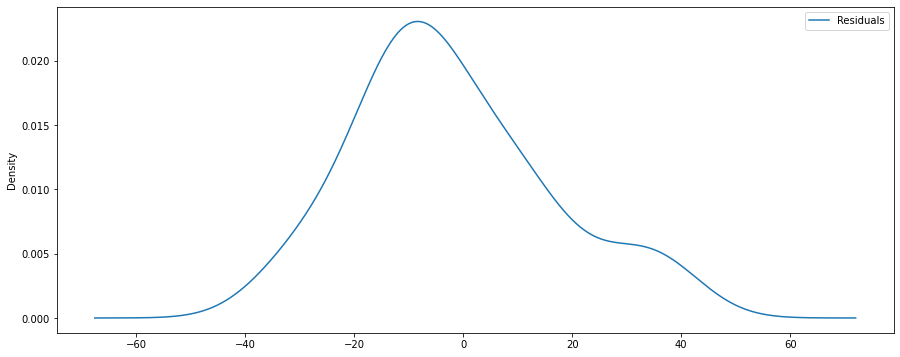

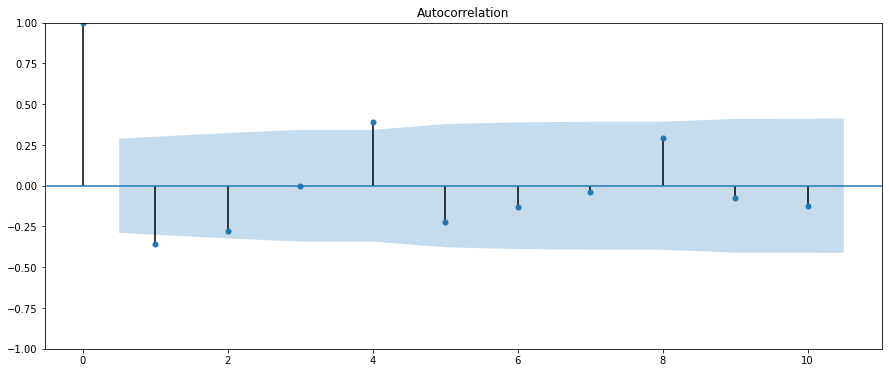

In [129]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

residuals = model_mlp.predict(X_test)-y_test
residuals.rename(columns={"target": "Residuals"}, inplace=True)
residuals.plot(label="Residuals")
residuals.plot.kde()
plot_acf(residuals, lags=10);

from statsmodels.tsa.stattools import adfuller

adf = adfuller(residuals)
print(f'p-valor: {round(adf[1],4)}')

# **MODELO MLP COM GRIDSEARCH**

In [130]:
#Parâmetros para o gridsearch
mlp_parameters = {'hidden_layer_sizes':[(10), (50), (100), (10,50), (50,50)],
                  'activation': ['identity', 'relu', 'tanh'],
                  'solver': ['adam', 'sgd']
                  }
mlp_parameters

{'hidden_layer_sizes': [10, 50, 100, (10, 50), (50, 50)],
 'activation': ['identity', 'relu', 'tanh'],
 'solver': ['adam', 'sgd']}

In [131]:
from sklearn.neural_network import MLPRegressor

mlp2 = MLPRegressor(random_state = 1, max_iter=500)
mlp_gridCV = GridSearchCV(
    estimator = mlp2,
    param_grid = mlp_parameters,
    n_jobs = -1,
    cv = TimeSeriesSplit()
)

In [132]:
%%time
model_mlp_gs = mlp_gridCV.fit(X_train, y_train.values.ravel())
model_mlp_gs.best_params_

CPU times: user 974 ms, sys: 33.5 ms, total: 1.01 s
Wall time: 17.8 s


{'activation': 'identity', 'hidden_layer_sizes': 100, 'solver': 'adam'}

In [133]:
mlp_gs_previsao = model_mlp_gs.predict(X_test)
mlp_gs_previsao

array([78.74305203, 63.73747171, 76.35424008, 82.22826476, 54.41571239,
       73.32171086, 56.81518094, 59.73947599, 52.76506327, 55.18080296,
       61.5794472 , 54.59941066, 56.65653597, 55.27447768, 57.07932407,
       70.3921799 , 44.91237045, 62.57438052, 49.04131036, 52.03372171,
       43.9586768 , 51.43522539, 51.23055739, 53.9917418 , 51.49107596,
       55.75810875, 51.22060241, 65.2653106 , 41.0024313 , 55.4555994 ,
       44.14763608, 49.61447949, 43.08781137, 46.8529817 , 47.3663615 ,
       47.42114631, 48.18211516, 49.86604579, 55.64028257, 65.86232729,
       45.53045181, 60.28427382, 47.98668991, 53.6142202 , 37.04646641,
       47.4471648 ])

In [134]:
mlp_gs_mse = mean_squared_error(y_test, mlp_gs_previsao).round(4)
mlp_gs_mae = mean_absolute_error(y_test, mlp_gs_previsao).round(4)
mlp_gs_mape = mean_absolute_percentage_error(y_test, mlp_gs_previsao).round(4)

resultados['MLP GS'] = {'mse': mlp_gs_mse, 'mae': mlp_gs_mae, 'mape': mlp_gs_mape}

round(pd.DataFrame(resultados),4)

,"ARIMA (11,1,1)",ARIMA 1step ahead,"AUTOARIMA (0,1,1)","AUTOARIMA (2,1,0)",SARIMA,SVR 2 splits,SVR 3s GS Valid,SVR 3s GS Teste,SVR 3s GS Valid J11,SVR 3s GS Teste J11,SVR_GSCV,MLP,MLP GS
mse,870.5675,94.7992,795.36,264.8965,223.1979,454.5102,719.2524,2011.7926,705.7844,2266.7737,1980.0382,317.6594,287.4476
mae,27.6062,7.8395,20.67,13.6311,12.3170,17.3425,22.4788,42.6210,23.0128,45.6041,42.0666,14.5039,12.3900
mape,0.5997,0.1634,0.25,0.2927,0.2405,0.2564,0.3225,0.9525,0.3268,1.0309,0.9548,0.2908,0.2723


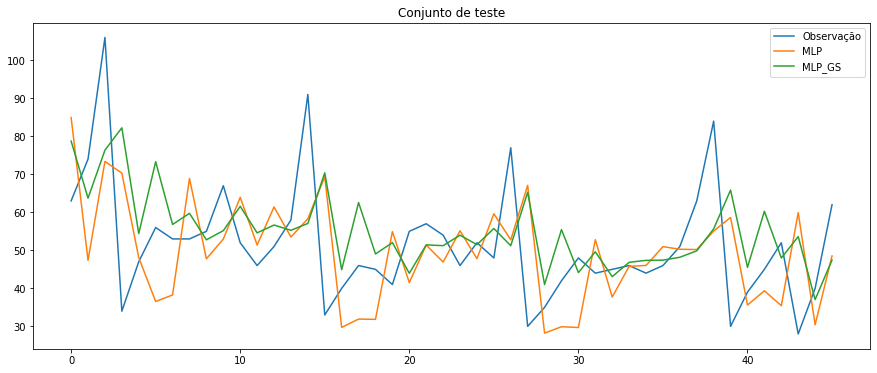

In [135]:
fig, ax = plt.subplots()
ax.plot(y_test.values, label = 'Observação')
ax.plot(mlp_previsao, label = 'MLP')
ax.plot(mlp_gs_previsao, label = 'MLP_GS')
plt.title('Conjunto de teste')
plt.legend()

In [ ]:
# por que deu ruim denovoooo, se MLP funcionou?????

residuals2 = mlp_gs_previsao-y_test
residuals2.rename(columns={"target": "Residuals"}, inplace=True)
residuals2.plot(label="Residuals")
residuals2.plot.kde()
plot_acf(residuals2, lags=10);

adf2 = adfuller(residuals2)
print(f'p-valor: {round(adf2[1],4)}')

# **VENDO TODO MUNDO**

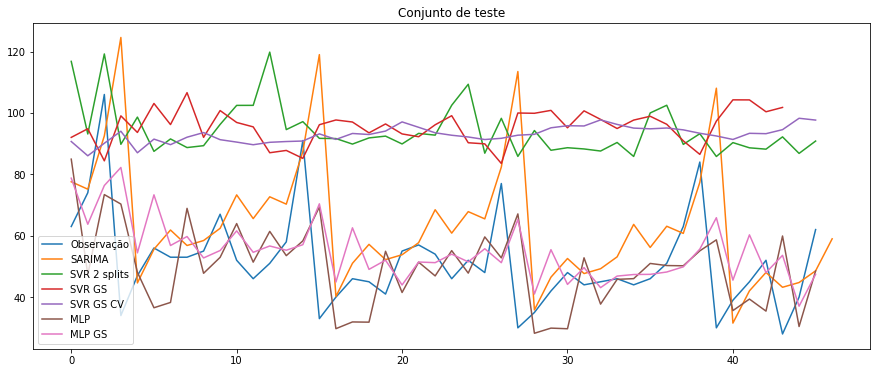

In [139]:
fig, ax = plt.subplots()
ax.plot(y_test.values, label = 'Observação')
ax.plot(pred.replace({0:None}).values, label = 'SARIMA')
ax.plot(svr_previsao, label = 'SVR 2 splits')
ax.plot(svr_previsao2, label = 'SVR GS')
ax.plot(svr_gscv_previsao, label = 'SVR GS CV')
ax.plot(mlp_previsao, label = 'MLP')
ax.plot(mlp_gs_previsao, label = 'MLP GS')

plt.title('Conjunto de teste')
plt.legend()

# LIXO

o gráfico do resíduo deveria girar em torno de zero, distribuição normal e o p-value do teste estatístico.

## Eliminação da tendência por diferenciação

In [ ]:
df_1ordem = df.diff()
plt.plot(df_1ordem, label="Diff - 1ª Ordem")
plt.legend(loc='best')
plt.show()

In [ ]:
# A 13a observação será a média das 11 anteriores
rolmean12 = df.diff().rolling(window = 12).mean()
rolstd12 = df.diff().rolling(window = 12).std()
plt.figure(figsize=(7, 5))
actual = plt.plot(df['target'].diff(), color='black', label='Time Series', alpha=0.7)
rm_12 = plt.plot(rolmean12, color='red', label='RM_12', linestyle='dotted')#, 'bo') 
std_12 = plt.plot(rolstd12, color='blue', label='STD_12', linestyle='dashed')#, fmt='2')
plt.legend(loc='best')
plt.show()

In [ ]:
plot_acf(df_1ordem.dropna(), lags=12, alpha=0.5);

In [ ]:
plot_pacf(df_1ordem.dropna(), lags=12, alpha=0.5);


In [ ]:
df_2ordem = df_1ordem.diff()
plt.plot(df_2ordem, label="Diff - 2ª Ordem")
plt.legend(loc='best')
plt.show()

In [ ]:
plot_acf(df_2ordem.dropna(), lags=12, alpha=0.5);
plot_pacf(df_2ordem.dropna(), lags=12, alpha=0.5);

In [ ]:
df_decomp2 = tsa.seasonal_decompose(df_2ordem.dropna(), period=12)